### Импортим библиотеки и df

In [310]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [311]:
df = pd.read_csv("Student Depression Dataset.csv",index_col="id")

### Подготовка к анализу данных

In [312]:
amount_uniq = {}
for i in list(df.columns):
    amount_uniq[i] = len(df[i].unique())
amount_uniq

{'Gender': 2,
 'Age': 34,
 'City': 52,
 'Profession': 14,
 'Academic Pressure': 6,
 'Work Pressure': 3,
 'CGPA': 332,
 'Study Satisfaction': 6,
 'Job Satisfaction': 5,
 'Sleep Duration': 5,
 'Dietary Habits': 4,
 'Degree': 28,
 'Have you ever had suicidal thoughts ?': 2,
 'Work/Study Hours': 13,
 'Financial Stress': 6,
 'Family History of Mental Illness': 2,
 'Depression': 2}

Выделим основные колонки, которые можно попытаться "сжать" с помощью метода главных компонент или убрать вовсе

In [313]:
corr_cols = [i for i in list(amount_uniq.keys()) if amount_uniq[i]<=6] + ['Degree','Profession']
corr_cols.remove("Depression") # т.к целевая переменная

In [314]:
df[corr_cols].info()

<class 'pandas.core.frame.DataFrame'>
Index: 27901 entries, 2 to 140699
Data columns (total 12 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Gender                                 27901 non-null  object 
 1   Academic Pressure                      27901 non-null  float64
 2   Work Pressure                          27901 non-null  float64
 3   Study Satisfaction                     27901 non-null  float64
 4   Job Satisfaction                       27901 non-null  float64
 5   Sleep Duration                         27901 non-null  object 
 6   Dietary Habits                         27901 non-null  object 
 7   Have you ever had suicidal thoughts ?  27901 non-null  object 
 8   Financial Stress                       27898 non-null  float64
 9   Family History of Mental Illness       27901 non-null  object 
 10  Degree                                 27901 non-null  object 
 11  Profes

Теперь проверим на Nan-ы.

In [315]:
df.isna().sum()

Gender                                   0
Age                                      0
City                                     0
Profession                               0
Academic Pressure                        0
Work Pressure                            0
CGPA                                     0
Study Satisfaction                       0
Job Satisfaction                         0
Sleep Duration                           0
Dietary Habits                           0
Degree                                   0
Have you ever had suicidal thoughts ?    0
Work/Study Hours                         0
Financial Stress                         3
Family History of Mental Illness         0
Depression                               0
dtype: int64

<Axes: >

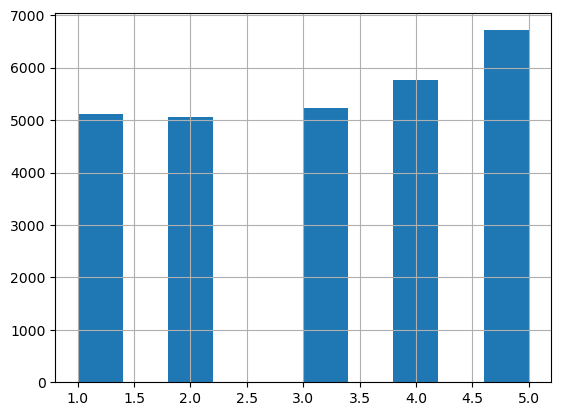

In [316]:
df["Financial Stress"].hist()

In [317]:
df["Financial Stress"] = df["Financial Stress"].fillna(df["Financial Stress"].mean())

### Преобразуем df

Сделаю следующее. Для данных бинарного типа оставлю только одну колонку с 1/0 соответственно.
А для данных текстовых данных можно применить label encoding.
Потому что данные можно представить в порядке убывания / возрастания, 
логически проранжировать их.
Нет смысла делать таблицу более разряженой

In [318]:
for i in corr_cols:
    print(i,'//',df[i].unique(),'//',df[i].dtype)

Gender // ['Male' 'Female'] // object
Academic Pressure // [5. 2. 3. 4. 1. 0.] // float64
Work Pressure // [0. 5. 2.] // float64
Study Satisfaction // [2. 5. 3. 4. 1. 0.] // float64
Job Satisfaction // [0. 3. 4. 2. 1.] // float64
Sleep Duration // ['5-6 hours' 'Less than 5 hours' '7-8 hours' 'More than 8 hours' 'Others'] // object
Dietary Habits // ['Healthy' 'Moderate' 'Unhealthy' 'Others'] // object
Have you ever had suicidal thoughts ? // ['Yes' 'No'] // object
Financial Stress // [1.         2.         5.         3.         4.         3.13986666] // float64
Family History of Mental Illness // ['No' 'Yes'] // object
Degree // ['B.Pharm' 'BSc' 'BA' 'BCA' 'M.Tech' 'PhD' 'Class 12' 'B.Ed' 'LLB' 'BE'
 'M.Ed' 'MSc' 'BHM' 'M.Pharm' 'MCA' 'MA' 'B.Com' 'MD' 'MBA' 'MBBS' 'M.Com'
 'B.Arch' 'LLM' 'B.Tech' 'BBA' 'ME' 'MHM' 'Others'] // object
Profession // ['Student' 'Civil Engineer' 'Architect' 'UX/UI Designer'
 'Digital Marketer' 'Content Writer' 'Educational Consultant' 'Teacher'
 'Manager' 

In [319]:
sex_dict = {"Male": 1, "Female": 0}
sleep_dict = {"Others": 0,"Less than 5 hours": 1,"5-6 hours": 2,"7-8 hours": 3,"More than 8 hours": 4}
dietary_dict = {"Others": 0,"Unhealthy": 1,"Moderate": 2,"Healthy": 3}
thoughts_dict = {"Yes": 1, "No": 0}
family_ill_dict = {"Yes": 1,"No": 0}

# Также занесем оставшиеся 2 колонки
education_dict = {
    'Class 12': 1,  # Школьное образование
    'B.Ed': 2, 'B.Pharm': 2, 'BSc': 2, 'BA': 2, 'BCA': 2, 'B.Com': 2, 'BHM': 2, 'B.Arch': 2, 'BE': 2, 'B.Tech': 2, 'LLB': 2, 'MBBS': 2, 'BBA': 2,  # Бакалавриат
    'M.Ed': 3, 'M.Pharm': 3, 'MSc': 3, 'MA': 3, 'M.Com': 3, 'MCA': 3, 'ME': 3, 'M.Tech': 3, 'LLM': 3, 'MHM': 3, 'MBA': 3, 'MD': 3,  # Магистратура
    'PhD': 4,  # Докторантура
    'Others': 0  # Другое
}
qualification_dict = {
    # Начинающий уровень / Стажёры
    'Student': 1,

    # Специалисты с базовым образованием
    'Civil Engineer': 2, 
    'Architect': 2,    
    'UX/UI Designer': 2,
    'Digital Marketer': 2,
    'Content Writer': 2, 
    'Teacher': 2,       
    'Chef': 2,           
    'Pharmacist': 2,   

    # Высококвалифицированные специалисты
    'Doctor': 3,      
    'Lawyer': 3,   
    'Manager': 3,  
    'Educational Consultant': 3,
    
    # Топ-уровень (руководители/владельцы)
    'Entrepreneur': 4
}

In [320]:
transform_dicts = [sex_dict,sleep_dict,dietary_dict,thoughts_dict,family_ill_dict,education_dict,qualification_dict]
columns_to_transform = [i for i in corr_cols if str(df[i].dtype) == "object"]

In [321]:
for i in range(len(columns_to_transform)):
    df[columns_to_transform[i]] = df[columns_to_transform[i]].map(transform_dicts[i])

In [322]:
print(len(df["City"].unique()))

52


Мы потеряем часть дисперсии, но при этом не сделаем таблицу разряженной

In [323]:
df = df.drop(columns=["City"])

Теперь весь датасет переведен в числовые значения, продолжим анализ

### Анализ данных

In [324]:
corrMatrix = df.corr(method="spearman") #  Т.к на данные применили label encoding

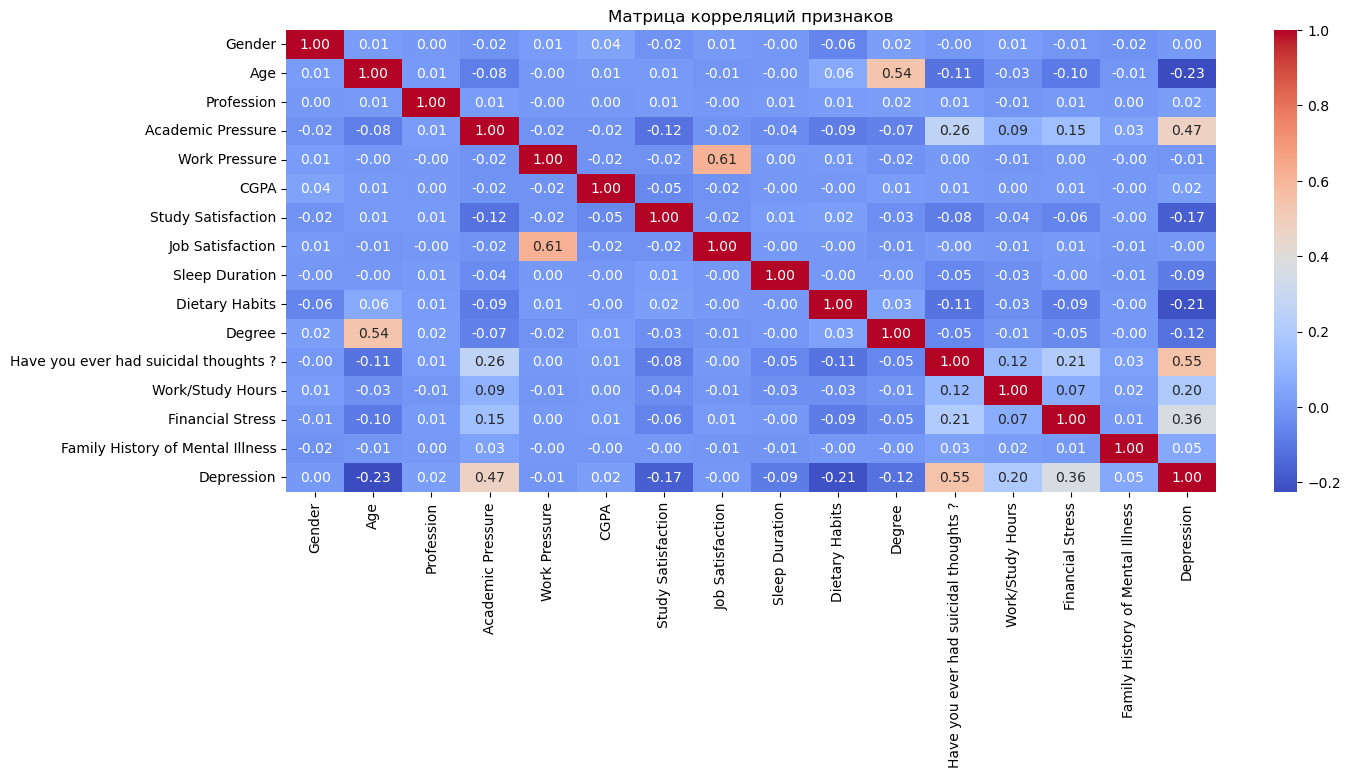

In [325]:
plt.figure(figsize=(15, 6))
sns.heatmap(corrMatrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Матрица корреляций признаков')
plt.show()

In [326]:
print(round(df["Work Pressure"].var(),5),round(df["Job Satisfaction"].var(),5))

0.00194 0.00197


Дисперсия двух величин близка к 0.
Потому использовать PCA нет смысла, а лучше сделать drop некоторых колонок

In [327]:
df = df.drop(columns=["Work Pressure","Degree"])

In [328]:
df = df.astype(float)

### Пишем fit/predict (Линейная регрессия)

In [329]:
y = df["Depression"]
X = df.drop(columns=["Depression"])

In [330]:
X_train,X_test,y_train,y_test = train_test_split(X,y,train_size=0.75,random_state=42)

In [331]:
model = LogisticRegression(penalty='l2')
model.fit(X_train,y_train)
y_pred = model.predict(X_test)

In [332]:
acc1 = accuracy_score(y_test,y_pred)

### Пишем fit/predict (Random forest)

In [333]:
model = RandomForestClassifier()
param_grid = {
    'n_estimators' : [50,100,150],
    'max_depth' : [i for i in range(3,5+1)]
}

In [334]:
grid_search = GridSearchCV(estimator=model,param_grid=param_grid,scoring='accuracy')

In [335]:
grid_search.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'max_depth': [3, 4, 5],
                         'n_estimators': [50, 100, 150]},
             scoring='accuracy')

In [336]:
best_model = grid_search.best_estimator_

In [337]:
y_pred = best_model.predict(X_test)

In [338]:
acc2 = accuracy_score(y_test,y_pred)